In [1]:
import sys 
sys.path.append('../../')  
from main import device_process_measurement_tomography, Quantities, Cross_Quantities
import QuantumTomography as qt 
import matplotlib.pyplot as plt 
import numpy as np 
from qiskit import QuantumCircuit, Aer, IBMQ 
from qiskit.compiler import transpile 
import json 
from qiskit.result import Result 
from qiskit.test.mock import FakeCasablanca  
from utils_qiskit import * 

In [2]:
IBMQ.load_account()
device = FakeCasablanca()

In [3]:
jobs = ['data/618b14fdeb64113dd7bb6080-output.json',
        'data/618b15007cdad6feb7ec066e-output.json',
        'data/618b150282271e07df2b280b-output.json',
        'data/618b15051452776ec0118c69-output.json']

data = []
for job in jobs:
    with open(job, 'r') as f:
        data.append( dict2results( json.load(f) ) )

results = CombineResults( data )
del data

In [4]:
dpmt = device_process_measurement_tomography( device)
circuits_dpmt = dpmt.circuits(label_qubits=False )

In [5]:
circuits_dpmt[0].name, circuits_dpmt[64].name, circuits_dpmt[82].name  

('circuit_gate_set_7_0', 'circuit_mpt_1_7_0_0', 'circuit-450')

In [6]:
results_tomography = dpmt.fit( results, paralell=True, gate_set=True )         
results_single     = results_tomography.single                             
results_double     = results_tomography.double                            
results_gateset    = results_tomography.gateset                            

In [7]:
quantities = []
pairs_qubits = []

for idx1 in range(3):
    for idx2 in range(2):

        qubit0 = dpmt._parall_qubits[idx1][idx2][0]
        qubit1 = dpmt._parall_qubits[idx1][idx2][1]
        pairs_qubits.append( '({},{})'.format(qubit0,qubit1) ) 

        choi0=results_single.chois[qubit0]
        choi1=results_single.chois[qubit1]
        povm0=results_single.povms[qubit0]
        povm1=results_single.povms[qubit1]

        choi01=results_double[idx1].chois[idx2]
        povm01=results_double[idx1].povms[idx2]

        Fs0 = Quantities( povm0, choi0 )
        Fs1 = Quantities( povm1, choi1 )
        Fs01 = Quantities( povm01, choi01 )
        Cs  = Cross_Quantities( povm0, choi0, povm1, choi1, povm01, choi01 )

        F0 = Fs0[0]
        F1 = Fs1[0]
        F01 = Fs01[0]
        cF = abs( F01 - F0*F1 ) 

        Q0 = Fs0[1]
        Q1 = Fs1[1]
        Q01 = Fs01[1]
        cQ = abs( Q01 - Q0*Q1 ) 

        # quantities.append(  [Fs0,Fs1,Fs01,Cs,[cF,cQ]] )
        quantities.append( Cs )

In [8]:
IDX = [ 3, 4, 0, 2, 1, 5 ]
pairs_qubits

['(1,3)', '(4,5)', '(3,5)', '(0,1)', '(1,2)', '(5,6)']

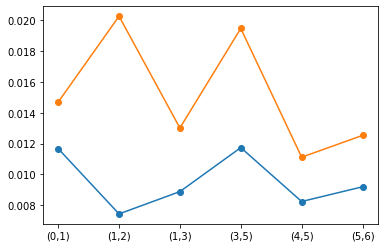

In [9]:
plt.plot( np.array(quantities)[IDX], '-o' )
plt.xticks( range(6), labels=np.array(pairs_qubits)[IDX] );

In [10]:
quantities

[(0.008886149224179568, 0.013011416889488207),
 (0.008243220674370399, 0.011116589833295857),
 (0.011738575630365618, 0.019466260978589986),
 (0.011672841396064478, 0.01468874593813094),
 (0.007438582225263954, 0.020257286631894737),
 (0.0091975514166324, 0.01253139152425478)]

In [11]:
# psi = np.array([1,1])/np.sqrt(2)
psi = np.array([1,0])
psi01 = np.kron( psi, psi )
rho01 = np.outer( psi01, psi01.conj())
rhov01 = rho01.flatten()

In [12]:
rhov01_0 = choi01[0]@rhov01  
rho01_0 = rhov01_0.reshape(4,4) 
print( np.trace( rho01_0 ) ) 
rho01_0 = rho01_0 / np.trace( rho01_0 ) 


(0.9737310385336396+0j)


In [13]:
from QuantumTomography import PartialTrace 
rhor0 = PartialTrace( rho01_0, [2,2], 1 )
np.trace( rhor0@rhor0 ) # 1 separable, 0.5 entrelazado

(0.9868343932094762+0j)

In [17]:
DeltaL = 2**13*( np.sum(np.array(results_single.entropies),1) 
                - np.sum(np.array(results_single.funs),1) )
DeltaL

array([15.39752048, 13.22069047,  3.6425636 , 19.59922773,  7.0009647 ,
        4.4985919 , 12.7662689 ])

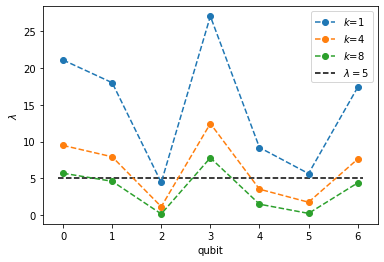

In [14]:
DeltaN = 4  
lambda_4 = abs( 2*DeltaL-DeltaN )/np.sqrt( 2*DeltaN )  
DeltaN = 1
lambda_1 = abs( 2*DeltaL-DeltaN )/np.sqrt( 2*DeltaN ) 
DeltaN = 8
lambda_8 = abs( 2*DeltaL-DeltaN )/np.sqrt( 2*DeltaN ) 

plt.plot( range(7), lambda_1, '--o',label='$k$=1')
plt.plot( range(7), lambda_4, '--o',label='$k$=4')
plt.plot( range(7), lambda_8, '--o',label='$k$=8')
plt.hlines( 5, -0.1, 6.1, color='black', linestyles='dashed', label='$\lambda=5$'  )
plt.legend()
plt.xlabel('qubit')
plt.ylabel('$\lambda$')
plt.savefig('goodness_of_fit_1q.png')

In [16]:
DeltaL = np.abs([ 2**13*( np.sum(np.array(results_double[k].entropies),1) 
                - np.sum(np.array(results_double[k].funs),1) ) for k in range(3) ])
DeltaL

array([[128.06401287,  72.93014233],
       [ 49.06708183,  12.78587974],
       [  3.70390586,  12.08876097]])

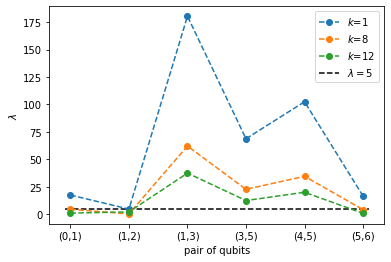

In [15]:
DeltaN = 20
lambda_12 = ( abs( 2*DeltaL-DeltaN )/np.sqrt( 2*DeltaN ) ).flatten()
DeltaN = 1
lambda_1 = ( abs( 2*DeltaL-DeltaN )/np.sqrt( 2*DeltaN ) ).flatten()
DeltaN = 8
lambda_8 = ( abs( 2*DeltaL-DeltaN )/np.sqrt( 2*DeltaN ) ).flatten()

Idx = [3,4,0,2,1,5]
plt.plot( range(6), lambda_1[Idx], '--o',label='$k$=1')
plt.plot( range(6), lambda_8[Idx], '--o',label='$k$=8')
plt.plot( range(6), lambda_12[Idx], '--o',label='$k$=12')
plt.hlines( 5, -0.1, 5.1, color='black', linestyles='dashed', label='$\lambda=5$'  )
plt.xticks( range(6), labels=[ '(0,1)', '(1,2)', '(1,3)', '(3,5)', '(4,5)', '(5,6)' ] )
plt.legend()
plt.xlabel('pair of qubits')
plt.ylabel('$\lambda$')
plt.savefig('goodness_of_fit_2q.png')